In [56]:
import numpy as np
#pip install pysindy
import pysindy as psd
from data_loader import data_loader_noH
import numpy as np
import matplotlib.pyplot as plt
from utils import params
from sklearn.metrics import mean_squared_error as mse

In [57]:
x_train, dx_train, x_val, dx_val = data_loader_noH()

In [58]:
library = psd.PolynomialLibrary(degree=2)
model = psd.SINDy(optimizer=psd.STLSQ(threshold=0.001), feature_library=library)

In [59]:
model.fit(x_train, t = 1, x_dot=dx_train)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
                     'x9'],
      optimizer=STLSQ(threshold=0.001))

In [60]:
def MAPE(y_true, y_pred):
    mask = y_true != 0
    y_true, y_pred = np.array(y_true)[mask], np.array(y_pred)[mask]
    if len(y_true) == 0:
        return np.nan
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
theta = np.array(library.transform(x_val))
sindy_coeff = np.transpose(model.coefficients())
dx_predict = np.matmul(theta, sindy_coeff)

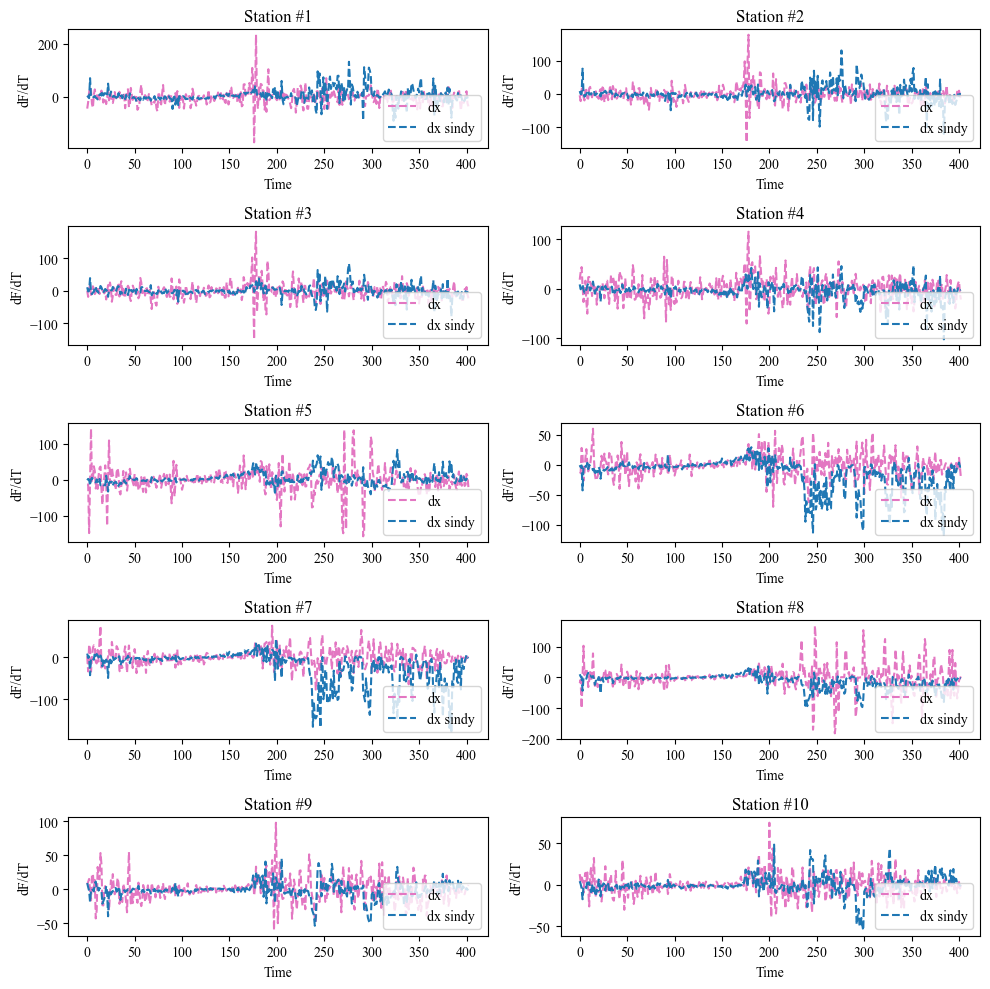

In [62]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

# Plot each column in a separate subplot
for row in range(5):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(100*dx_val[:, row*2 + col], "--", color = '#e377c2', label = 'dx')
        axs[row, col].plot(100*dx_predict[:, row*2 + col], "--", color = '#1f77b4' ,label = 'dx sindy')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('dF/dT')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/dz_dzSINDy_Plot.png", dpi=300)

In [63]:
from sindy_utils import sindy_library
sim_result_1 = np.zeros(x_val.shape)
sim_result_2 = np.zeros(x_val.shape)
sim_result_3 = np.zeros(x_val.shape)

In [64]:
for t in range(x_val.shape[0]):
    x_init = x_val[t,:].reshape(1,-1)
    Theta_curr = np.array(library.transform(x_init))
    dx_curr = np.matmul(Theta_curr, sindy_coeff)
    x_new = x_init + dx_curr
    sim_result_1[t,:] = x_new

In [65]:
# fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(9, 15))
# for i in range(6):
#     axs[i].plot(100*sim_result_1[:-1, i], label = '5mins Predicted')
#     axs[i].plot(100*x_val[1:,i], label = 'Original')
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

In [66]:
np.save("Pred_Results/one_step_pred_sindy.npy", sim_result_1)
np.save("Pred_Results/x_val_sindy.npy", x_val)

In [67]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*x_val[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [68]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/Sindy.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,52.65,46.03,44.28,44.58,60.34,42.18,53.31,65.7,29.01,25.67


In [69]:
# MAPE
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*x_val[1:,i], 100*sim_result_1[:-1, i])
    mape_i[f'Station #{i+1}'] =mape_curr

In [70]:
accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/Sindy_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,10.07,11.4,10.5,10.15,16.4,16.62,20.04,20.2,15.12,21.96


In [71]:
for t in range(sim_result_1.shape[0]):
    z_current = sim_result_1[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_2[t,:] = z_next

In [75]:
# fig, axs = plt.subplots(nrows=params['partial_measurement'], ncols=1, figsize=(9, 15))
# for i in range(params['partial_measurement']):
#     axs[i].plot(100*sim_result_2[:-2, i], label = '10mins Predicted')
#     axs[i].plot(100*x_val[2:,i], label = 'Original')
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

In [76]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100 * sim_result_2[:-2, i], 100 * x_val[2:, i]))
    rmse_i[f'Station #{i + 1}'] = rmse_curr

In [77]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindy_10mins.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,91.32,75.67,65.34,55.65,74.12,56.82,76.22,88.46,42.61,43.09


In [78]:
# MAPE
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100 * x_val[2:, i], 100 * sim_result_2[:-2, i])
    mape_i[f'Station #{i+1}'] =mape_curr

In [79]:
accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/sindy_10mins_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,14.66,15.98,14.26,12.91,20.68,21.14,27.12,26.25,19.9,30.87


In [20]:
# for t in range(sim_result_2.shape[0]):
#     z_current = sim_result_2[t,:].reshape(1,-1)
#     Theta_curr = sindy_library(z_current,2,False)
#     dz_curr = np.matmul(Theta_curr, sindy_coeff)
#     z_next = z_current + dz_curr
#     sim_result_3[t,:] = z_next

In [21]:
# rmse_i = {}
# for i in range(params['partial_measurement']):
#     rmse_curr = np.sqrt(mse(100 * sim_result_3[:-3, i], 100 * x_val[3:, i]))
#     rmse_i[f'Station #{i + 1}'] = rmse_curr

In [23]:
# accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
# accuracy.to_csv("Accuracy_Metric/sindy_15mins.csv")
# accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,217.58,171.02,109.16,82.05,93.31,68.43,93.0,109.07,71.36,81.49


In [24]:
import random
indices = range(6)
index_pair = []
for i in range(6):
    for j in range(i+1, 6):
        index_pair.append((indices[i], indices[j]))
random.seed(100)
index_pair = random.sample(index_pair, 6)

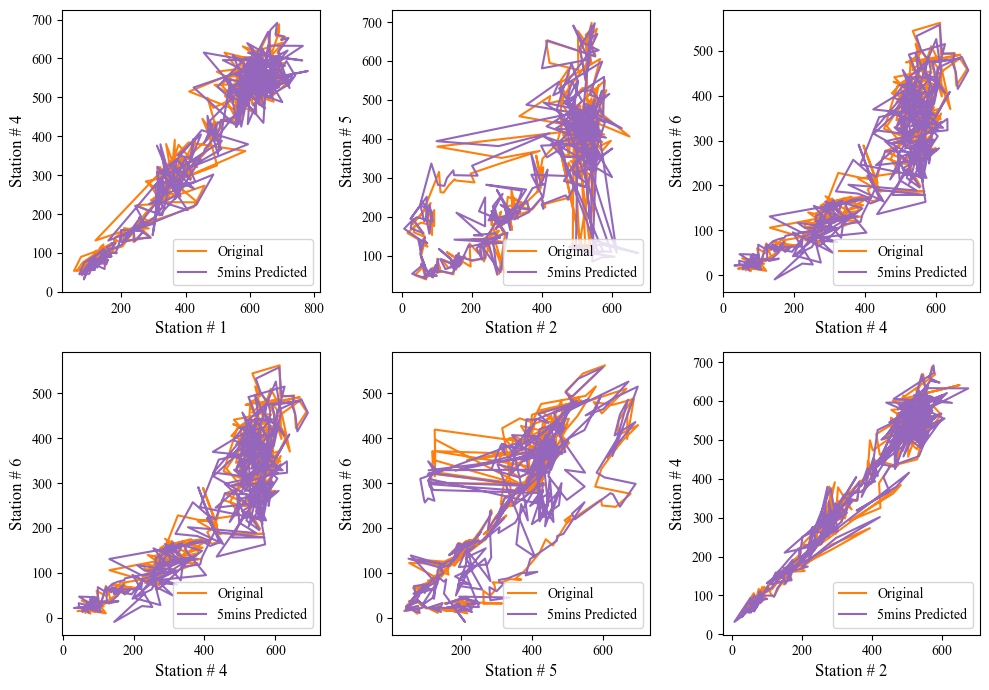

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        axs[row, col].plot(100 * x_val[:-1,index1], 100 * x_val[:-1,index2], color = '#ff7f0e', label = 'Original')
        axs[row, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], color = '#9467bd', label = '5mins Predicted')
        #axs[row, col].plot(100 * X_ori[1:,index1], 100 * X_ori[1:,index2], "--", label = '5mins Predicted')
        axs[row, col].legend(loc='lower right', fontsize='medium')
        axs[row, col].set_xlabel(f'Station # {index1 + 1}', fontsize = 12)
        axs[row, col].set_ylabel(f'Station # {index2 + 1}', fontsize = 12)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/predicted_and_z_phase.png", dpi = 300)